# Libraries

In [71]:
import warnings
warnings.filterwarnings("ignore")

# import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.keras.backend.set_floatx('float64')

# import tensorflow.python.util.deprecation as deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False

In [72]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import math
import pickle
import time
import timeit
from   tqdm    import tqdm
import pandas  as pd
import numpy   as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot                        as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow
from   tensorflow.keras.models                  import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics import RegressionEvaluation


print('[INFO] Libraries imported')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[INFO] Libraries imported


# Parameters

In [73]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## CUDA

In [74]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Training paramers

In [75]:
Lag        =   12
Horizon    =    2
#
epochs     =  100
batch_size =  128

Transformation = True

# Importing data

In [76]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Data concern the concentration from a mine in Norway
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

 

# # Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'



# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.41 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


In [77]:
# # Parameters
# #
# filename   = '../Data/D-6-It.csv'

# Transformation  = True
# Scaling         = 'Standard'




# # Start timer
# #
# start = time.time()

# # Load data
# #
# df = pd.read_csv(filename, 
#                  sep = ',')


# # Rename columns
# #
# df = df.rename(columns = {'created_at' : 'Date',
#                           'field1' : 'Temperature',
#                           'field2' : 'Humidity',
#                           'field3' : 'PM2.5',
#                           'field4' : 'PM10',
#                           'field5' : 'NO2',
#                           'field6' : 'CO',
#                           'field7' : 'NH4',})



# # End timer
# #
# print('[INFO] Time: %.2f' % (time.time() - start))

# df.head( 3 )

## Preprocess

In [78]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('10min').mean()
# df = pd.DataFrame( df[['Temperature', 'Humidity', 'NO2', 'CO']] )

# The last feature is the target variable
df = pd.DataFrame( df[ ['NO2', 'CO'] ] )
# df = pd.DataFrame( df[ 'CO' ] )


df.head(3)

,NO2,CO
Date,,
2022-02-19 00:00:00,168.631579,240.710526
2022-02-19 00:10:00,135.394737,227.473684
2022-02-19 00:20:00,141.447368,229.526316


## Include MA-based features

In [79]:
# df['MA6']  = df[ targetSeries ].rolling(6).mean()
# df['MA12'] = df[ targetSeries ].rolling(12).mean()

# df['Hour'] = df.index.hour

In [80]:
# Set target series/Series which will be forecasted
# 
targetSeries = df.columns[-1]

# Set all other utilized features
Features = df.columns[:-1]

## Split Training/Testing set

In [81]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

In [82]:
print('Training: ', df_train.shape[0])
print('Testing:  ', df_test.shape[0])

Training:  8558
Testing:   2140


## Visualize Training & Testing data

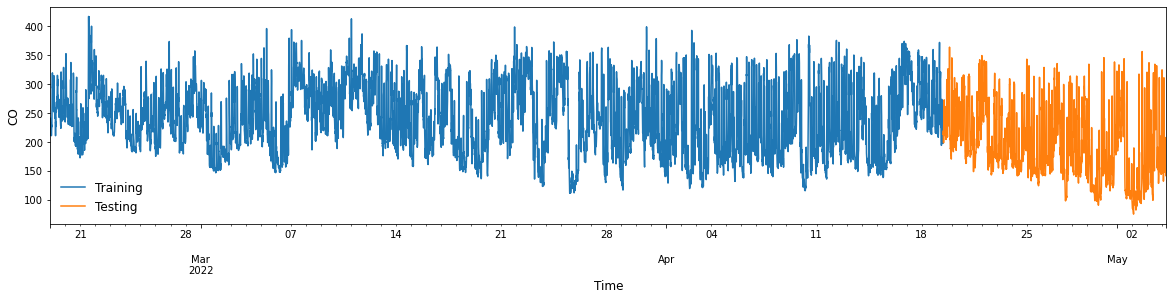

In [83]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Testing'], fontsize = 12, frameon = False);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

## Fix lag

In [84]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Contruction of fitting data for training a forecasting model

### Data Transformation

In [85]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ) + 1.0, 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)

    # # Transformation parameter
    # #
    # d = {'parameter': VALUE}

    # import json
    # with open('checkpoints/Transformation.json', 'w') as fp:
    #     json.dump(d, fp)
    # print('[INFO] Parameters saved')

else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


### Data scaling 

In [86]:
import pickle

if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # # Save Scaler
    # #
    # filename = 'checkpoints/Feature_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # # Save Scaler
    # #
    # filename = 'checkpoints/Target_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Target scaler saved in ', filename)

    
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # # Save Scaler
    # #
    # filename = 'checkpoints/Feature_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # # Save Scaler
    # #
    # filename = 'checkpoints/Target_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Target scaler saved in ', filename)
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    # Set scaler
    #
    scaler = StandardScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # # Save Scaler
    # #
    # filename = 'checkpoints/Feature_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # # Save Scaler
    # #
    # filename = 'checkpoints/Target_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Target scaler saved in ', filename)       
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   


# # Save Scaler
# #
# filename = 'checkpoints/Target_scaler.pkl'
# pickle.dump(scaler, open(filename, 'wb'))
# print('[INFO] Target scaler saved in ', filename)      

[INFO] Scaling: Standard


### Include date/time features

In [87]:
# df_train['Time (sin)'] = np.sin( df_train.index.hour + df_train.index.minute / 60 )
# df_train['Time (cos)'] = np.cos( df_train.index.hour + df_train.index.minute / 60 )
# #
# df_test['Time (sin)']  = np.sin( df_test.index.hour + df_test.index.minute / 60 )
# df_test['Time (cos)']  = np.cos( df_test.index.hour + df_test.index.minute / 60 )

### Create fitting data 

In [88]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1, includeDate = False):
    
    if (targetSeries is None):
        print('[INFO] Target series is not defined')
        return (None, None, None)
    
    dataX, CurrentValue, dataY = [], [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Check for NaN values
        if (df[i:i + Lag + Horizon].dropna().shape[0] != df[i:i + Lag + Horizon].shape[0]): continue
        
        # Instances: Lag-d differences
        Instance  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy().tolist() 
        
        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist(), 
                       np.cos(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            Instance = np.concatenate([Instance, myDate], axis = -1)

        # Current value
        CurrentValue.append( df[ targetSeries ].to_numpy()[i+Lag-1] )
        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY), np.array(CurrentValue) )

In [89]:
trainX, trainY, _                = create_dataset(df           = df_train, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,
                                                  overlap      = 1,)

testX,  testY, test_CurrentValue = create_dataset(df           = df_test, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,                                                
                                                  overlap      = Horizon,)


# trainX = np.expand_dims(trainX, axis=-1)
# testX  = np.expand_dims(testX, axis=-1)
print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 1070/1070 [00:03<00:00, 272.78it/s]


Training instances:     8545
Testing instances:      1070


# Forecasting model

In [90]:
# Define metrics
#
metrics = [
            MeanAbsolutePercentageError(name = "MAPE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]

In [91]:
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.models                  import *
# Inputs
#
Inputs = Input(shape = (trainX.shape[1], trainX.shape[2]))


# Encoder
#
Encoder = LSTM(units = 100, activation='relu')( Inputs )
# Decoder
#
Decoder = RepeatVector( Horizon )(Encoder)
#
Decoder = LSTM(units = 100, activation='relu')(Decoder)

# Output
#
# Outputs =  TimeDistributed(Dense(1, activation='linear'))( Decoder )
Outputs =  Dense( Horizon, activation='linear' )( Decoder )


# Create model
#
model = Model(inputs = Inputs, outputs = Outputs)

## Training forecasting model

In [92]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [93]:
# Checkpoint
#
checkpoint = ModelCheckpoint("checkpoints/Seq2Seq_LSTM_diff.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
#
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 10)

In [94]:
# Start clock
#
start = timeit.default_timer()


score = model.fit(trainX, trainY, 
                  epochs           = epochs, 
                  batch_size       = batch_size, 
                  callbacks        = [checkpoint, earlystopping, lrs_scheduler],
                  verbose          = True, 
                  shuffle          = True,
                  validation_split = 0.2)


# Terminate clock
#
stop = timeit.default_timer()

Epoch 1/100
54/54 [==============================] - 7s 36ms/step - loss: 0.1908 - MAE: 0.2818 - RMSE: 0.4368 - val_loss: 0.2620 - val_MAE: 0.3305 - val_RMSE: 0.5118 - lr: 5.0000e-04
Epoch 2/100
54/54 [==============================] - 1s 22ms/step - loss: 0.1819 - MAE: 0.2791 - RMSE: 0.4265 - val_loss: 0.2516 - val_MAE: 0.3247 - val_RMSE: 0.5016 - lr: 5.0000e-04
Epoch 3/100
54/54 [==============================] - 1s 24ms/step - loss: 0.1792 - MAE: 0.2783 - RMSE: 0.4234 - val_loss: 0.2495 - val_MAE: 0.3276 - val_RMSE: 0.4995 - lr: 5.0000e-04
Epoch 4/100
54/54 [==============================] - 1s 25ms/step - loss: 0.1776 - MAE: 0.2786 - RMSE: 0.4214 - val_loss: 0.2464 - val_MAE: 0.3244 - val_RMSE: 0.4964 - lr: 5.0000e-04
Epoch 5/100
54/54 [==============================] - 1s 22ms/step - loss: 0.1766 - MAE: 0.2773 - RMSE: 0.4203 - val_loss: 0.2424 - val_MAE: 0.3229 - val_RMSE: 0.4924 - lr: 5.0000e-04
Epoch 6/100
54/54 [==============================] - 1s 24ms/step - loss: 0.1759 - MA

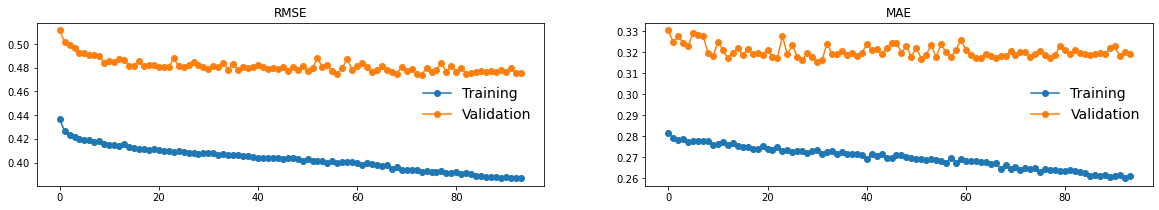

In [95]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized forecasting model

In [96]:
# Load the best model
#
model.load_weights('checkpoints/Seq2Seq_LSTM_diff.hdf5')

# Evaluation

## Get predictions

In [97]:
# Get predictions
#
pred = model.predict( testX )

## Inverse "Lag-d Diff" transformation

In [98]:
for i in range( Horizon ):
    testY[:, i] = test_CurrentValue - testY[:, i]
    pred[:, i]  = test_CurrentValue - pred[:, i]

## Apply inverse scaling/transformation

In [99]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set

In [100]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE 16.06 RMSE 28.13 SMAPE:  7.59 R2: 0.79
Horizon:  2 MAE 26.79 RMSE 45.68 SMAPE: 12.84 R2: 0.46


### Reliability evaluation

[INFO] Feature:  CO
------------------------------------------------


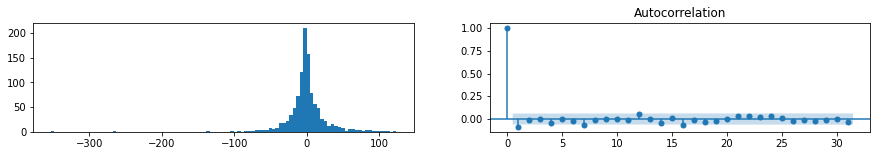

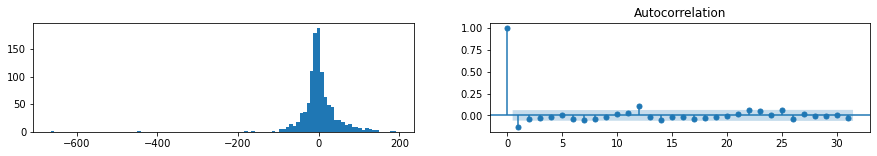

In [101]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization

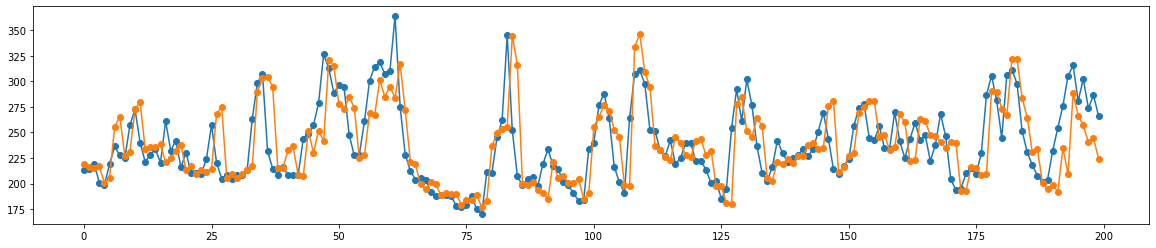

In [102]:
Prices = pd.DataFrame( [] )

Prices[targetSeries] = testY.flatten()
Prices['Prediction'] = pred.flatten()


# Plot results
#
plt.figure( figsize = (20, 4) );
#
Prices[ targetSeries ][:200].plot(color = 'tab:blue', marker = 'o')
Prices[ 'Prediction' ][:200].plot(color = 'tab:orange', marker = 'o')
plt.show();


### Examples

In [103]:
# subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
# plt.figure( figsize = (20, 8) )
# RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
# RandomInstances = [66, 62, 192, 448, 477, 1035, 34, 408, 860]

# for plot_id, i in enumerate(RandomInstances):

#     plt.subplot(subplots[plot_id])
#     plt.grid()

#     plt.plot(testY[i], color='g', marker = 'o', linewidth = 2)
#     plt.plot(pred[i],  color='r', marker = 'o', linewidth = 2)

#     plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
#     plt.ylim([90, 260])
# plt.show()

# Store predictions

In [104]:
Outputs = pd.DataFrame( [] )


Outputs[ targetSeries ] = testY.flatten()
Outputs['Seq2Seq_LSTM_diff'] = pred.flatten()

Outputs.to_csv('Predictions/Seq2Seq_LSTM_diff.csv')